In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown as md

from natural_cycles_assignment.import_data import load_and_clean_data

2025-06-21 19:14:42.486 | INFO     | natural_cycles_assignment.config:<module>:11 - PROJ_ROOT path is: D:\Files\Projects\Code\natural-cycles-assignment


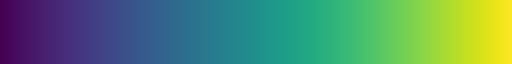

In [2]:
# Set up plotting style
plt.style.use("seaborn-v0_8")
sns.color_palette("viridis", as_cmap=True)

# Load data

In [3]:
import pandas as pd

df = pd.read_csv("../data/external/ncdatachallenge-2021-v1.csv", index_col=0)

print(df.shape)
df.head()

(1995, 13)


,bmi,age,country,been_pregnant_before,education,sleeping_pattern,n_cycles_trying,outcome,dedication,average_cycle_length,cycle_length_std,regular_cycle,intercourse_frequency
0,22.942130,31,SE,"No, never",University,Wake same every workday,1,pregnant,0.640000,25.588235,2.526332,True,0.200000
1,19.886054,34,NaN,NaN,University,NaN,7,pregnant,0.009569,30.875000,3.522884,True,0.052632
2,29.323049,41,SE,"No, never",University,Several times during the night,4,not_pregnant,0.298246,27.666667,2.503331,True,0.149123
3,24.386526,27,SE,"No, never",High school,Wake same every workday,2,pregnant,0.895833,24.250000,3.453776,True,0.145833
4,29.299971,29,SE,"No, never",Trade/technical/vocational training,Wake same every day,2,pregnant,0.666667,25.466667,0.990430,True,0.254902


## Data completeness

In [4]:
# Count NaN's in each column
print("NaN count:\n", df.isna().sum())

NaN count:
 bmi                        0
age                        0
country                  113
been_pregnant_before     317
education                391
sleeping_pattern         499
n_cycles_trying            0
outcome                    0
dedication                 0
average_cycle_length       6
cycle_length_std          25
regular_cycle              6
intercourse_frequency      0
dtype: int64


Comments of Jeroen:

Only country, been_pregnant_before, education, sleeping pattern, cycle_length_sd and regular_cycle contain NaN values

When analysing which factors involve pregnancy it might be necessary to drop these samples.

In [5]:
md(f"{df.dropna().shape[0]}/{df.shape[0]} samples do not contain NaN values.")

1185/1995 samples do not contain NaN values.

## Outlier + data range inspection

In [6]:
def safe_min_max(series: pd.Series) -> pd.Series:
    """For each numeric column, return the min and max values. If the column is not numeric, return None for both min and max."""
    try:
        return pd.Series({"min": series.min(), "max": series.max()})
    except TypeError:
        return pd.Series({"min": None, "max": None})


min_max_summary = df.apply(safe_min_max)
print(min_max_summary.T)  # transpose for better readability

                                min         max
bmi                             0.0   50.611299
age                              19          44
country                        None        None
been_pregnant_before           None        None
education                      None        None
sleeping_pattern               None        None
n_cycles_trying                   1          26
outcome                not_pregnant    pregnant
dedication                      0.0    1.347826
average_cycle_length           19.5       145.5
cycle_length_std                0.0  168.998521
regular_cycle                 False        True
intercourse_frequency           0.0    0.793103


Original dataset shape: (1995, 13)
Cleaned dataset shape: (1995, 13)


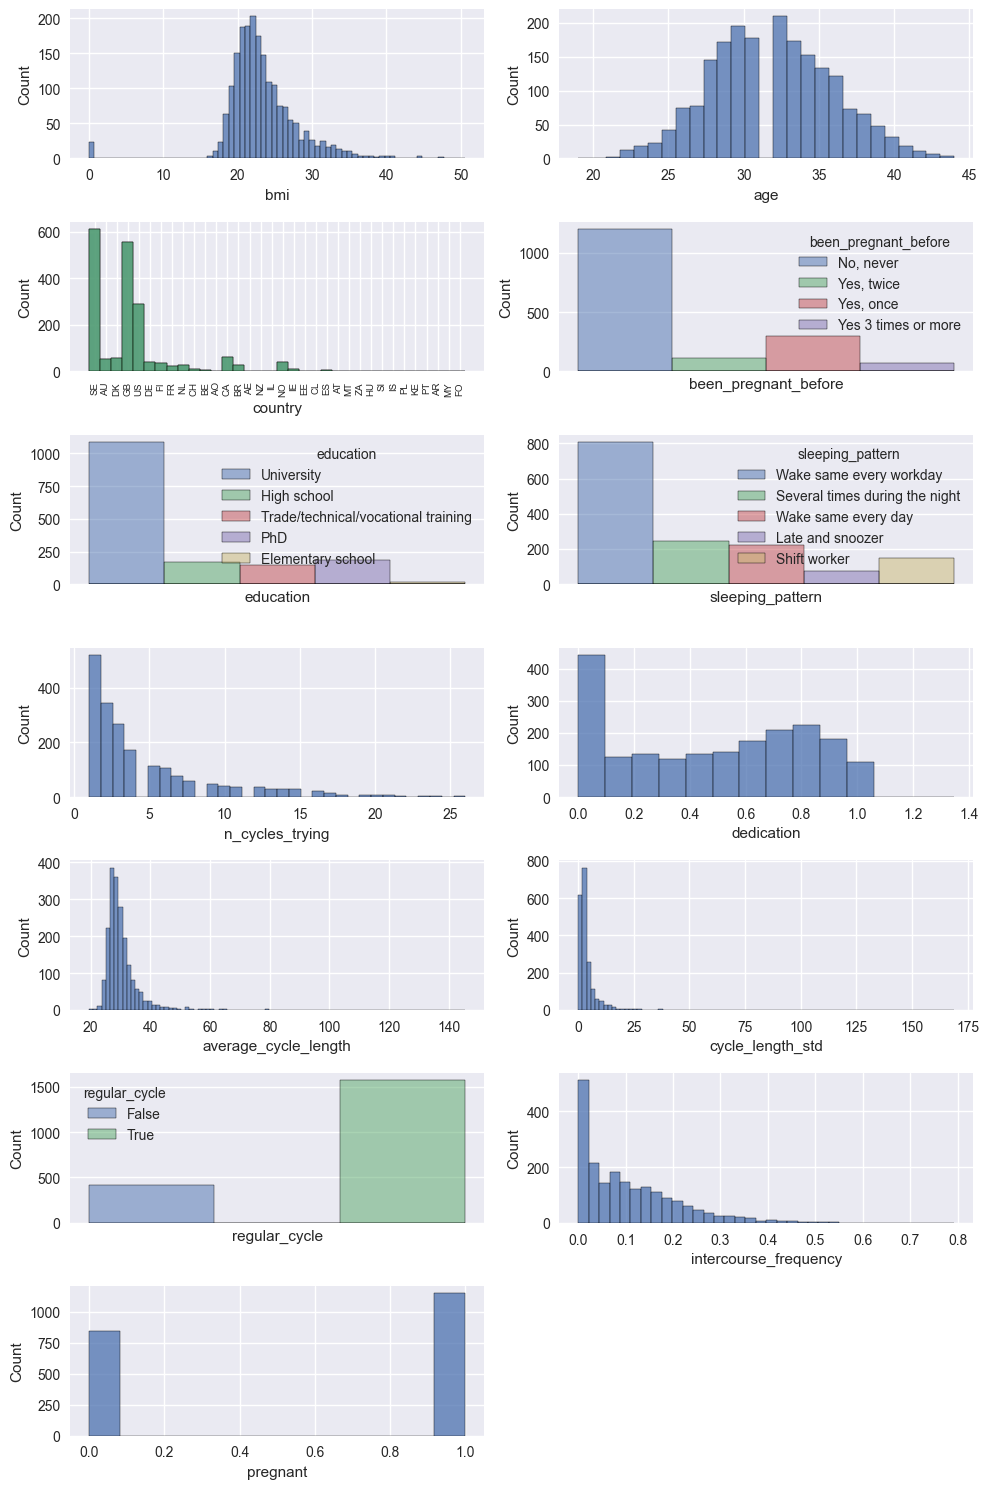

In [7]:
plt.figure(figsize=(10, 15))

df_cleaned = load_and_clean_data(
    csv_file="../data/external/ncdatachallenge-2021-v1.csv", clean_outliers=False, remove_na=False
)

for i, column in enumerate(df_cleaned.columns):

    plt.subplot(int(np.ceil(df.shape[1] / 2)), 2, i + 1)

    if column == "country":
        sns.histplot(df_cleaned, x=column)
        plt.tick_params(axis="x", rotation=90, labelsize=7)
    if column in [
        "been_pregnant_before",
        "education",
        "sleeping_pattern",
        "regular_cycle",
        "outcome"
    ]:
        bins = len(df_cleaned[column].unique())
        sns.histplot(df_cleaned, x=column, hue=column, bins=bins)
        # Decrease legend size
        handles, labels = plt.gca().get_legend_handles_labels()
        if handles:
            plt.legend(title="", fontsize="xx-small")
        # Remove xticks
        plt.xticks([])

    else:
        sns.histplot(df_cleaned, x=column)

plt.tight_layout()
plt.savefig(
    "../reports/figures/EDA_data_exploration_histograms.png", dpi=300, bbox_inches="tight"
)

plt.show()

Comments Jeroen:

Most variables do not show any noteworthy outliers.

BMW ranges from 13 to 50, which are both quite extreme values: BMI 13 being extremely underweight and 50 very high. Both are not impossible though, so I am hesitant of throwing these out. 

# Correlation Analysis

In [8]:
csv_file = "../data/external/ncdatachallenge-2021-v1.csv"

# Load and clean data + remove na
df_no_nan = load_and_clean_data(csv_file=csv_file, clean_outliers=False, remove_na=True)

# Only consider women who got pregnant for this analysis
df_pregnant = df_no_nan[df_no_nan["pregnant"] == 1].copy()

# Drop country column as there are too many unique values and too little sampels
df_pregnant = df_pregnant.drop(columns=["country", "pregnant"])

df_pregnant.head()

Original dataset shape: (1995, 13)
Removing all rows with missing values
Cleaned dataset shape: (1185, 13)


,bmi,age,been_pregnant_before,education,sleeping_pattern,n_cycles_trying,dedication,average_cycle_length,cycle_length_std,regular_cycle,intercourse_frequency
0,22.942130,31,"No, never",University,Wake same every workday,1,0.640000,25.588235,2.526332,True,0.200000
3,24.386526,27,"No, never",High school,Wake same every workday,2,0.895833,24.250000,3.453776,True,0.145833
4,29.299971,29,"No, never",Trade/technical/vocational training,Wake same every day,2,0.666667,25.466667,0.990430,True,0.254902
9,27.450228,28,"No, never",University,Wake same every workday,1,0.000000,32.285714,4.214053,True,0.193548
10,22.812519,38,"Yes, twice",PhD,Wake same every day,5,0.908163,26.250000,1.770122,True,0.193878



Correlation matrix of numeric variables:


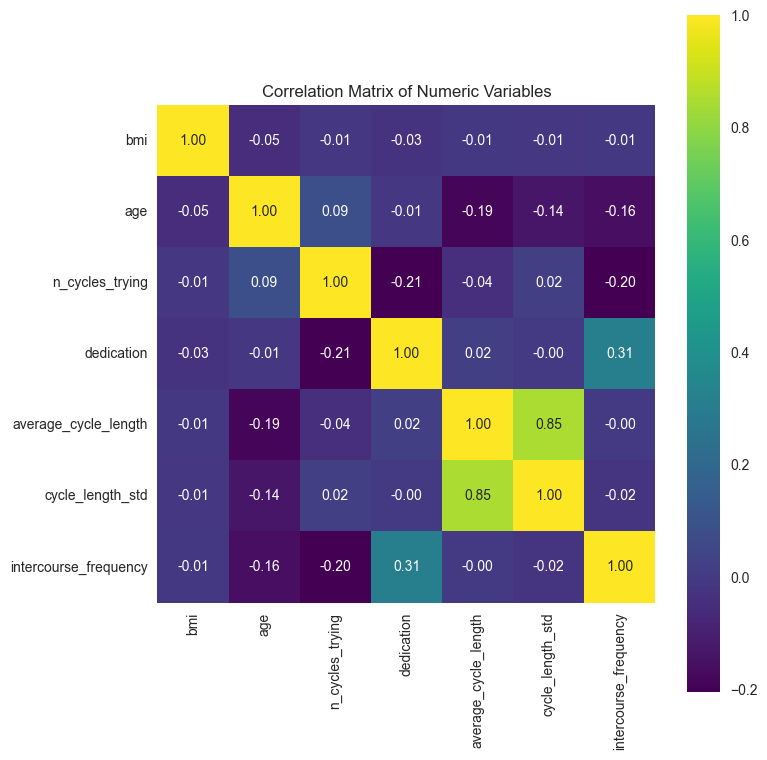

In [9]:
# Correlation analysis
print("\nCorrelation matrix of numeric variables:")
numeric_cols = df_pregnant.select_dtypes(include=[np.number]).columns
corr_matrix = df_pregnant[numeric_cols].corr()

# Plot correlation matrix
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="viridis", square=True)
plt.title("Correlation Matrix of Numeric Variables")
plt.tight_layout()
plt.savefig("../reports/figures/EDA_correlation_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

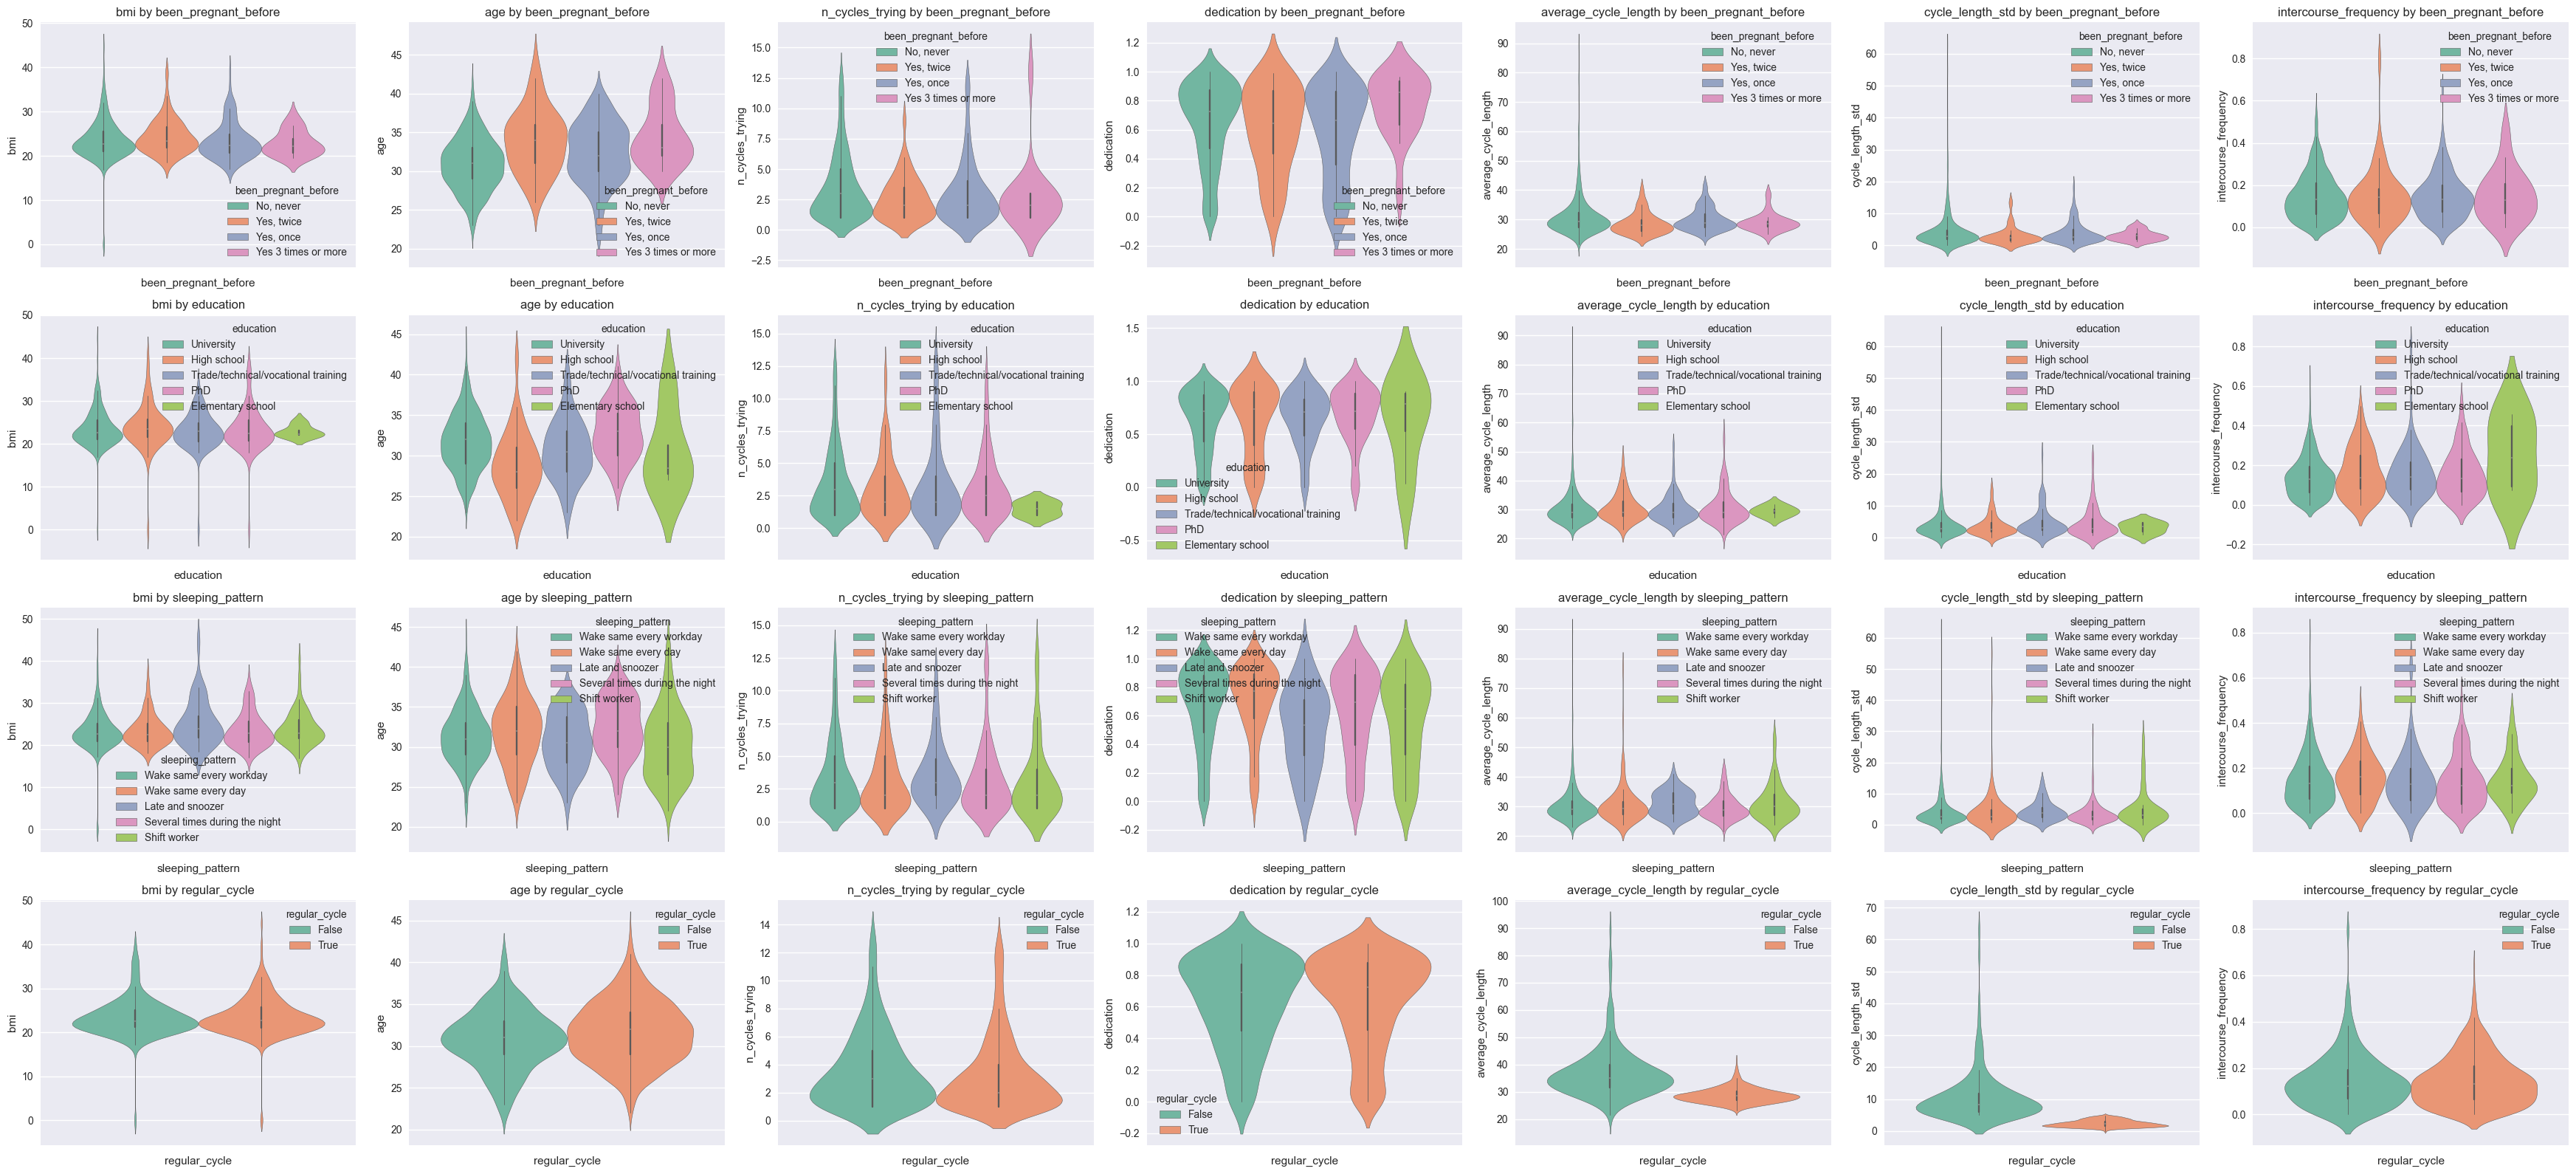

In [10]:
# Violin plots: categorical vs numeric variables
categorical_cols = df_pregnant.select_dtypes(
    include=["object", "category", "bool"]
).columns
# Exclude 'country' due to high cardinality
categorical_cols = [col for col in categorical_cols if col != "country"]
numeric_cols = df_pregnant.select_dtypes(include=[np.number]).columns

n_cat = len(categorical_cols)
n_num = len(numeric_cols)
fig, axes = plt.subplots(n_cat, n_num, figsize=(5 * n_num, 4 * n_cat), squeeze=False)

for i, cat_col in enumerate(categorical_cols):
    for j, num_col in enumerate(numeric_cols):
        ax = axes[i, j]
        sns.violinplot(
            data=df_pregnant,
            hue=cat_col,
            y=num_col,
            ax=ax,
            inner="box",
            palette="Set2",
        )
        ax.set_title(f"{num_col} by {cat_col}")
        ax.set_xlabel(cat_col)
        ax.set_ylabel(num_col)
        ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.savefig(
    "../reports/figures/EDA_violinplots_categorical_vs_numeric.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()